In [161]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
from collections import defaultdict
import matplotlib.pyplot as plt


In [162]:
path_to_project = "~/Downloads/AkeFiles/Files/project_ver2/new_version/ProteinLigandPredictor/structured"

# path to results of simulations (realValues)
rV_file_name = "list_of_ligand_out_for_Ragav.txt"
# path to predictions of 39 complexes with 10 poses (predictedValues)
pV_file_name = "logs/predictions_on_test_cases/390_predictions.csv"
# data for affinities of complexes (affinityBank)
aB_file_name = "formatted_binding.csv"

In [163]:
rV_file_path = (f"{path_to_project}/{rV_file_name}")
pV_file_path = (f"{path_to_project}/{pV_file_name}")
aB_file_path = (f"{path_to_project}/{aB_file_name}")

rV = pd.read_csv(rV_file_path, sep = "\t", names = ["rec","lig","dock","rmsd","pose","score"])
# Deleting the first row with titles
rV.drop(0, axis = 0, inplace = True)

pV = pd.read_csv(pV_file_path)
# Deleting the Unnamed column
pV.drop(["Unnamed: 0"], axis = 1, inplace = True)

aB = pd.read_csv(aB_file_path)
aB.drop(["Unnamed: 0"], axis = 1, inplace = True)

In [39]:
rV.head()

,rec,lig,dock,rmsd,pose,score
1,1rv1,1rv1,glide,7.16,4,-3.28
2,1rv1,1rv1,glide,7.62,6,-3.28
3,1rv1,1rv1,glide,8.64,10,-2.48
4,1rv1,1rv1,gold,6.71,3,56.04
5,1rv1,1rv1,gold,7.15,2,56.3


In [40]:
pV.head()

,predictions,data_codes
0,0.102954,1rv1_1
1,2.118930,1rv1_10
2,1.138494,1rv1_2
3,0.336687,1rv1_3
4,1.803915,1rv1_4


In [51]:
# The names of unique complex names
complex_list = list(rV['rec'].unique())
# Makking the code names uppercase for comparsion facilitation
complex_list = list(map(lambda x: x.upper(), complex_list))
len(complex_list)

39

In [371]:
from collections import defaultdict

class FormatOptions:
    '''Class works only 
    for specific data files
    '''
    
    @staticmethod
    def find_best_poses(data, data_code_key = "data_codes", affinity_key = "predictions", haspose = False):
        """Finds the best pose of each complex

        param data: the DataFrame of complexes
        param data_code_key: the name of the key for the code 
        param affinity_key: the name of the key for the affinity value

        return best_pose: the dict containing the key as a code and a value as a tuple of best pose
        """

        best_pose = defaultdict(list)

        for index, row in data.iterrows():
            compaired_value = row[affinity_key] if isinstance(row[affinity_key], float) else float(row[affinity_key])

            if not haspose:
                best_pose[row[data_code_key][:4]] = (compaired_value, row[data_code_key])
            else:
                best_pose[row[data_code_key][:4]] = (compaired_value, f"{row[data_code_key]}_{(index % 10) + 1}")

        return best_pose 
    
    @staticmethod
    def attach_index_or_upper(data, key_name, make_upper = False):
        '''Attaches the real pose index to the code names
        or make upper case of the code names
        
        param key_name: the attribute name for the code name
        param make_upper: whether to make uppercase of the result code name
        '''
        for index,row in data.iterrows():
            if not make_upper:
                row[key_name] = f"{row[key_name]}_{(index % 9) + 2}"
            else:
                row[key_name] = row[key_name].upper()
                
    @staticmethod 
    def reset_index(data):
        data.reset_index()
        if "index" in data.columns:
            data = data.drop(["index"], axis = 1)
        return data
        

In [339]:
# Exclude some columns from the realValues table and change their names
formatted_rV = rV.copy()
formatted_rV["Representative"] = formatted_rV["rec"]
formatted_rV.drop(["rec", "lig"], axis = 1, inplace = True)

In [340]:
formatted_rV.head()

,dock,rmsd,pose,score,Representative
1,glide,7.16,4,-3.28,1rv1
2,glide,7.62,6,-3.28,1rv1
3,glide,8.64,10,-2.48,1rv1
4,gold,6.71,3,56.04,1rv1
5,gold,7.15,2,56.3,1rv1


In [341]:
# change index so that it starts from zero and delete old index column
formatted_rV = formatted_rV.reset_index()
formatted_rV.drop(["index"], axis = 1, inplace = True)

# put right pose indices
FormatOptions.attach_index_or_upper(formatted_rV, "Representative")

In [342]:
formatted_rV.head()

,dock,rmsd,pose,score,Representative
0,glide,7.16,4,-3.28,1rv1_2
1,glide,7.62,6,-3.28,1rv1_3
2,glide,8.64,10,-2.48,1rv1_4
3,gold,6.71,3,56.04,1rv1_5
4,gold,7.15,2,56.3,1rv1_6


In [343]:
# types of docking 
formatted_rV["dock"].unique()

array(['glide', 'gold', 'vina'], dtype=object)

In [344]:
FormatOptionsformatted_rV["dock"].describe()

NameError: name 'FormatOptionsformatted_rV' is not defined

In [498]:
def make_dock_split(formatted_data, split_by, compare = "rmsd", relative = "score", useless_columns = ["pose"]):
    # split realValues by different docking type
    splitted = defaultdict(dict)
    
    for item in formatted_data[split_by].unique():
        splitted[item] = formatted_data.loc[formatted_data[split_by].isin([item])]
    # delete the useless columns and reset the indices of splitted tables
    for key in splitted.keys():
        splitted[key] = splitted[key].reset_index()
        splitted[key][compare] = splitted[key][compare].astype(float)
        splitted[key][relative] = splitted[key][relative].astype(float)
        splitted[key].drop(["index"], axis = 1, inplace = True)
        
        intersections = np.intersect1d(useless_columns, splitted[key].columns)
        
        if len(intersections) > 0:
            splitted[key].drop(useless_columns, axis = 1, inplace = True)
    
    return splitted

def compute_correlations(splitted_dict, compare = ["score", "rmsd"]):
    correlation = defaultdict(dict)
    for key in splitted_dict.keys():
        correlation[key] = (splitted_dict[key].loc[:, compare]).corr()
    return correlation

def plot_correlations(correlation):
    fig, axarr = plt.subplots(len(correlation.keys()), 1, figsize = (8, 8))

    for index, key in enumerate(correlation.keys()):
        ax = sns.heatmap(
            data = correlation[key],
            ax = axarr[index],
            annot = True,
            cbar_kws = {'label':key}
        )
        ax.figure.axes[-1].yaxis.label.set_size(20)

In [480]:
splitted_rV = make_dock_split(formatted_rV, split_by = "dock", compare = "rmsd", relative = "score", useless_columns = ["pose"])

In [481]:
for key in splitted_rV.keys():
    print(splitted_rV[key].head())
    print("*"*40)

    dock  rmsd  score Representative
0  glide  7.16  -3.28         1rv1_2
1  glide  7.62  -3.28         1rv1_3
2  glide  8.64  -2.48         1rv1_4
3  glide  0.42  -6.91         1t4e_2
4  glide  4.97  -4.91         1t4e_3
****************************************
   dock  rmsd  score Representative
0  gold  6.71  56.04         1rv1_5
1  gold  7.15  56.30         1rv1_6
2  gold  8.90  49.49         1rv1_7
3  gold  1.00  63.22         1t4e_5
4  gold  1.17  62.18         1t4e_6
****************************************
   dock  rmsd  score Representative
0  vina  0.38   -8.1         1rv1_8
1  vina  7.50   -5.9         1rv1_9
2  vina  8.47   -6.1        1rv1_10
3  vina  0.77   -8.5         1t4e_8
4  vina  4.67   -6.9         1t4e_9
****************************************


In [482]:
correlation_rV = compute_correlations(splitted_rV,compare = ["score", "rmsd"])

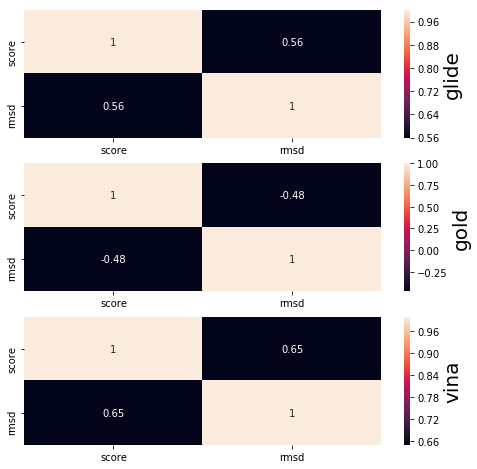

In [483]:
plot_correlations(correlation_rV)

In [347]:
formatted_pV = pV.copy()
formatted_pV["Representative"] = formatted_pV["data_codes"]

if "data_codes" in formatted_pV.columns:
    formatted_pV.drop(["data_codes"], axis = 1, inplace = True)

In [348]:
formatted_pV.shape

(390, 2)

In [349]:
formatted_rV.shape

(351, 5)

In [350]:
# Merge in relative to realValues (their shape is less) by the common column Representative
merged_real_predicted = pd.merge(formatted_rV, formatted_pV, on = "Representative")

In [351]:
print(merged_real_predicted.head())
print("*"*40)
print(formatted_rV.head())
print("*"*40)
print(formatted_pV.head())

    dock  rmsd pose  score Representative  predictions
0  glide  7.16    4  -3.28         1rv1_2     1.138494
1  glide  7.62    6  -3.28         1rv1_3     0.336687
2  glide  8.64   10  -2.48         1rv1_4     1.803915
3   gold  6.71    3  56.04         1rv1_5     0.437793
4   gold  7.15    2   56.3         1rv1_6     0.285932
****************************************
    dock  rmsd pose  score Representative
0  glide  7.16    4  -3.28         1rv1_2
1  glide  7.62    6  -3.28         1rv1_3
2  glide  8.64   10  -2.48         1rv1_4
3   gold  6.71    3  56.04         1rv1_5
4   gold  7.15    2   56.3         1rv1_6
****************************************
   predictions Representative
0     0.102954         1rv1_1
1     2.118930        1rv1_10
2     1.138494         1rv1_2
3     0.336687         1rv1_3
4     1.803915         1rv1_4


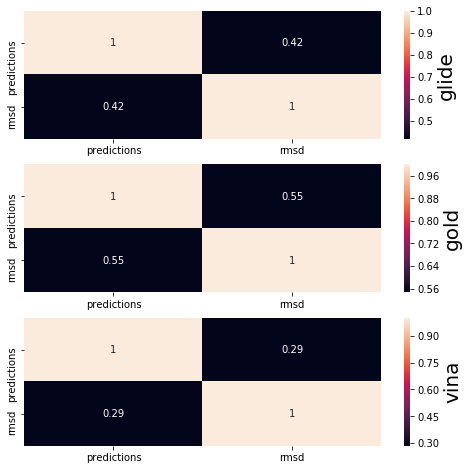

In [352]:
splitted_pV = make_dock_split(merged_real_predicted, split_by = "dock", compare = "rmsd", relative = "predictions",useless_columns = ["pose","score"])
correlation_pV = compute_correlations(splitted_pV,compare = ["predictions", "rmsd"])
plot_correlations(correlation_pV)

In [353]:
np.intersect1d(useless_columns, splitted[key].columns)

NameError: name 'splitted' is not defined

In [ ]:
'''
    Creating the table of rmsd versus predictions
    also counting the tenth pose for prediction 
    and setting rmsd for that pose as 0.1
'''

In [358]:
merged_rmsd_predictions = pd.merge(formatted_rV, formatted_pV,how = "outer", on = "Representative")

In [359]:
useless_columns = ["dock","pose","score"]

intersections = np.intersect1d(useless_columns, merged_rmsd_predictions.columns)

if len(intersections) == len(useless_columns):
    merged_rmsd_predictions.drop(useless_columns, axis = 1, inplace = True)

In [360]:
merged_rmsd_predictions.fillna(0.1, inplace = True)

In [361]:
merged_rmsd_predictions[380:390]

,rmsd,Representative,predictions
380,0.1,5j7f_1,0.222635
381,0.1,5j7g_1,0.019783
382,0.1,5lav_1,0.226968
383,0.1,5law_1,0.159922
384,0.1,5lay_1,0.032492
385,0.1,5laz_1,0.443592
386,0.1,5ln2_1,0.159485
387,0.1,5oc8_1,0.083629
388,0.1,5z02_1,0.037828
389,0.1,5zxf_1,0.059447


In [362]:
# Sort by Representative, so that the old order will preserve
merged_rmsd_predictions.sort_values(by = ["Representative"], inplace = True)

In [363]:
merged_rmsd_predictions.head()

,rmsd,Representative,predictions
351,0.1,1rv1_1,0.102954
8,8.47,1rv1_10,2.118930
0,7.16,1rv1_2,1.138494
1,7.62,1rv1_3,0.336687
2,8.64,1rv1_4,1.803915


In [375]:
merged_rmsd_predictions = FormatOptions.reset_index(merged_rmsd_predictions
                                                   )

In [404]:
merged_rmsd_predictions.head()

,rmsd,Representative,predictions
0,0.1,1rv1_1,0.102954
1,8.47,1rv1_10,2.118930
2,7.16,1rv1_2,1.138494
3,7.62,1rv1_3,0.336687
4,8.64,1rv1_4,1.803915


In [511]:
# The intersections of complex_list with affinity bank
intersections = (aB.loc[aB["Representative"].isin(complex_list)])
intersections_set = list(intersections["Representative"].unique())

In [516]:
 METRIC_CONVERT = {
        'mM':10**-3,
        'uM':10**-6,
        'pM':10**-12,
        'nM':10**-9,
        'fM':10**-15,
        'M':10**0
    }

def convert_to_log_10(row):
    row["Num"] *= METRIC_CONVERT[row["Unit"]]
    row["Num"] = (-1) * np.log10(row["Num"])
    return row
    
aB_intersected = aB.loc[aB["Representative"].isin(complex_list)]
aB_intersected = aB_intersected.apply(convert_to_log_10, axis = 1)
aB_intersected.head()

,Representative,Metric,Num,Unit
3057,4OAS,Kd,10.346787,nM
3058,3JZK,ic50,5.910095,uM
3059,4JV7,ic50,6.000000,uM
3061,5LN2,ic50,9.886057,nM
3063,4ZYF,Ki,8.886057,nM


In [517]:
# predictions of diferent poses versus one real affinity from affinity bank
p_v_r = merged_rmsd_predictions.copy()
# Add the column pose for easing the merging process
p_v_r["pose"] = p_v_r["Representative"]

In [518]:
# changing pose to numeric
def attach_pose_index(row):
    try:
        pose_index = int(row["pose"][-2:])
    except:
        pose_index = int(row["pose"][-1:])
    row["pose"] = pose_index
    row["Representative"] = row["Representative"][:4].upper()
    
    return row

# change from mol to -log10, counting the fact that 
# predictions are given in micromol
def convert_to_log_10(row):
    row["predictions"] /= 10**6
    row["predictions"] = (-1)*np.log10(row["predictions"])
    return row

mappings = [attach_pose_index,convert_to_log_10]
    

In [519]:
for mapping in mappings:
    p_v_r = p_v_r.apply(mapping, axis = 1)

In [520]:
p_v_r.head()

,rmsd,Representative,predictions,pose
0,0.1,1RV1,6.987357,1
1,8.47,1RV1,5.673883,10
2,7.16,1RV1,5.943669,2
3,7.62,1RV1,6.472773,3
4,8.64,1RV1,5.743784,4


In [521]:
if "rmsd" in p_v_r.columns:
    p_v_r.drop(["rmsd"], axis = 1, inplace = True)

In [522]:
# Since not all complexes have affinities from the affinity bank
p_v_r = p_v_r.loc[p_v_r["Representative"].isin(intersections_set)]
p_v_r.shape

(240, 3)

In [523]:
merged_p_v_r = pd.merge(p_v_r, aB_intersected, how = "outer", on = "Representative")

In [524]:
merged_p_v_r.shape

(240, 6)

In [528]:
merged_p_v_r["Representative"].unique()

array(['1RV1', '3JZK', '3LBL', '3TU1', '3W69', '4DIJ', '4ERF', '4HBM',
       '4JV7', '4JV9', '4MDN', '4MDQ', '4OAS', '4OCC', '4ODE', '4ODF',
       '4OGN', '4OGT', '4OQ3', '4QOC', '4WT2', '4ZGK', '4ZYF', '5LN2'],
      dtype=object)

In [526]:
# splitted by each complex, so each key contains small dataframe
splitted_by_repr = make_dock_split(merged_p_v_r, split_by = "Representative", compare = "predictions", relative = "Num", useless_columns = ["Unit"])

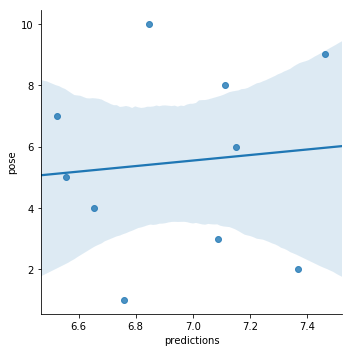

In [538]:
rv = splitted_by_repr["4ODE"]
sns.lmplot(x = "predictions", y = "pose", data = rv)